<a href="https://colab.research.google.com/github/twyeh/university-physics/blob/main/Copy_of_Buffon_needle_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as jnp
from jax import random
import time
import math
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.cm as cm
from matplotlib import pyplot as plt

jnp.set_printoptions(precision=3,suppress=True)

In [ ]:
def needle(N,key,len=1):
  #Simulates throwing N needles on a square grid of side length len
  #key is a Jax Random key
  #returns two arrays:
  # * an array of shape (N,2,2) with the locations of all the needles
  # * integer array of length N with the sequence of number of touches
  #   of each needle (i.e. each is 0,1,2)
  rando = random.uniform(key, (N,3)) #random numbers for coord geneartion, x,y,theta

  x_start = rando[:,0]  #x and y coordinates for the two endpoints of the grid
  y_start = rando[:,1]
  x_end = x_start + len*jnp.cos(rando[:,2]*2*jnp.pi)
  y_end = y_start + len*jnp.sin(rando[:,2]*2*jnp.pi)

  lines = jnp.stack([x_start,y_start,x_end,y_end]).reshape(2,2,N).transpose(2,0,1)#reshape into an (N,2,2) array for use in matplotlib later

  x_touch = jnp.floor(x_end) != jnp.floor(x_start) #they touch the grid if they round down to different numbers
  y_touch = jnp.floor(y_end) != jnp.floor(y_start)
  touches = 1*x_touch + 1*y_touch #convert booleans to integers and add the total number of touches (either 0,1 or 2) for each needle

  return lines, touches

12 estimates for Pi using 11 needles
[3.385 3.385 3.385 2.588 4.4   3.667 3.385 2.588 2.588 3.385 3.385 2.75 ]


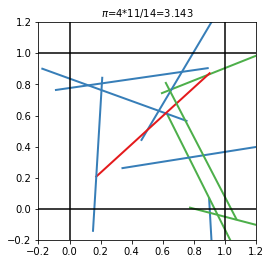

In [ ]:
def needle_pic(N,key):
  #displays a picture of running the experiment with N needles once
  #color of needle correponds to number of touches
  lines,touches = needle(N,key)

  line_colors =  cm.Set1(touches)
  lc = mc.LineCollection(lines, colors=line_colors, linewidths=2)
  fig, ax = plt.subplots()
  ax.set_aspect('equal')
  ax.add_collection(lc)
  N_touch = jnp.sum(touches)
  ttl = plt.text(0.5, 1.01, "$\pi$=4*{}/{}={:.3f}".format(N,N_touch,4*N/N_touch), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)

  border_size = 0.2
  ax.set(xlim=(-border_size, 1+border_size), ylim=(-border_size, 1+border_size))

  ax.axhline(0,color='black')#draw the gridlines
  ax.axhline(1,color='black')
  ax.axvline(0,color='black')
  ax.axvline(1,color='black')

def needle_pi(N,S,key,len=1):
  #returns an array of length S which consists of
  #S samples of estimating pi with buffon needle experiment with N needles
  cumulative_touches = jnp.cumsum(needle(S*N,key)[1])
  #generates S*N samples, and takes the cumulative sum to get how touches increase with samples
  num_touches = jnp.maximum(jnp.diff(cumulative_touches[N-1:S*N+1:N],prepend=0),jnp.ones(S))
  #break it up into blocks of size N. THen take the differences to get number of touches in each
  #note that we have to preapend a 0 to the thing when taking differences
  return 4*N/num_touches

key = random.PRNGKey(int(time.time()))
N=11
S=12
needle_pic(N,key)
print("{} estimates for Pi using {} needles".format(S,N))
print(needle_pi(N,S,key))


In [ ]:
def needle_counts(N,S,key,len=1):
  #returns an array of length S which consists of
  #S samples of estimating pi with buffon needle experiment with N needles
  cumulative_touches = jnp.cumsum(needle(S*N,key)[1])
  #generates S*N samples, and takes the cumulative sum to get how touches increase with samples
  num_touches = jnp.maximum(jnp.diff(cumulative_touches[N-1:S*N+1:N],prepend=0),jnp.ones(S))
  #break it up into blocks of size N. THen take the differences to get number of touches in each
  #note that we have to preapend a 0 to the thing when taking differences
  return num_touches
key = random.PRNGKey(int(time.time()))
N=11
S=10**6
P=10**2
targets = [12,13,14,15,16]
nums = [0]*len(targets)
for i in range(P):
  key, _ = random.split(key)
  dat = needle_counts(N,S,key)
  for j in range(len(targets)):
    nums[j] += jnp.count_nonzero(dat == targets[j])


print([ "{}: {:.2f}%".format(t,100*int(n)/P/S) for t,n in zip(targets,nums)])


['12: 12.13%', '13: 19.29%', '14: 22.25%', '15: 18.88%', '16: 11.88%']


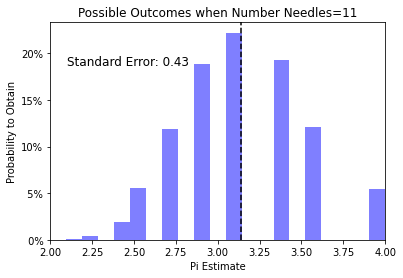

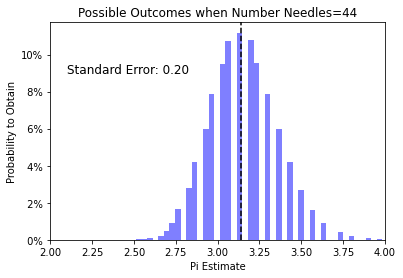

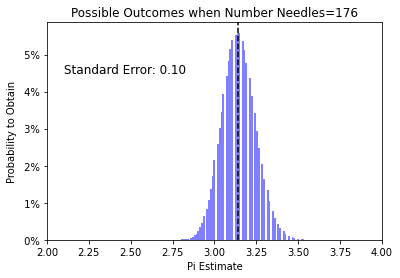

In [ ]:
def needle_pi_histogram(N,S):
  #Make a histogram of running the pi experiment with N needles using S samples
  key = random.PRNGKey(int(time.time()))
  data = needle_pi(N,S,key)
  fig, ax = plt.subplots()
  ax.set_title('Possible Outcomes when Number Needles={}'.format(N))
  ax.set_xlabel("Pi Estimate")
  ax.set_ylabel("Probability to Obtain")
  ax.set(xlim=(2, 4))

  #make sure each value gets its own bin
  d = jnp.diff(jnp.unique(data)).min()
  left_of_first_bin = data.min() - float(d)/2
  right_of_last_bin = data.max() + float(d)/2
  ax.hist(data, jnp.arange(left_of_first_bin, right_of_last_bin + d, d), facecolor='blue', alpha=0.5, label="Sample1",align='left')

  y_vals = ax.get_yticks()
  ax.set_yticklabels(['{:2.0f}%'.format(100*x/S) for x in y_vals])

  ax.axvline(math.pi,color='black',linestyle='dashed')

  rmse = jnp.sqrt(jnp.mean(jnp.square(data-math.pi)))
  ax.text(2.1,max(y_vals)*0.75, 'Standard Error: {:.2f}'.format(rmse),fontsize=12)

  fig.show()

needle_pi_histogram(11,10**6)
needle_pi_histogram(4*11,10**6)
needle_pi_histogram(16*11,10**6)

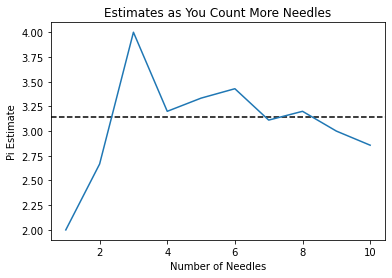

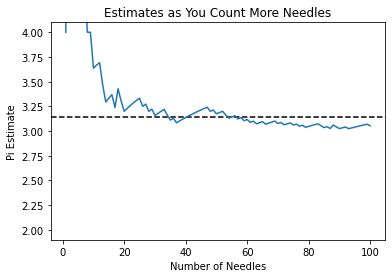

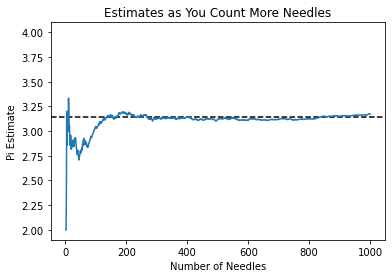

In [ ]:
def needle_history(N,S):
  #graph of the history of S samples as you increase from 1 needle to N needles in each sample
  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  ax.axhline(math.pi,color='black',linestyle='dashed')
  ax.set_title("Estimates as You Count More Needles")
  ax.set_xlabel("Number of Needles")
  ax.set_ylabel("Pi Estimate")

  #ax.set(ylim=(math.pi-5/math.sqrt(N), math.pi+5/math.sqrt(N)))
  ax.set(ylim=(1.9, 4.1))

  key = random.PRNGKey(int(time.time()))
  for i in range(S):
    key, subkey = random.split(key)
    touches = needle(N,key)[1]
    x = jnp.arange(1,N+1)
    y = 4*x/jnp.cumsum(touches)
    ax.plot(x,y)  # Plot some data on the axes.

needle_history(10,1)
needle_history(10**2,1)
needle_history(10**3,1)

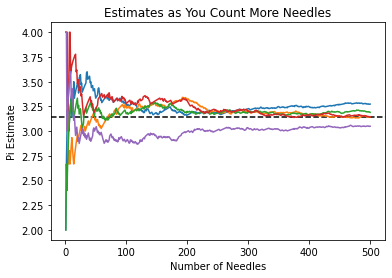

In [ ]:
needle_history(5*10**2,5)